In [ ]:
import math
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Numerical Solution for Capacity Modeling

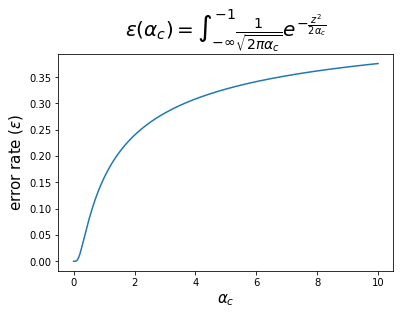

In [ ]:
alpha_c_np = np.linspace(0.001,10,200)
error_rates_np = np.zeros((len(alpha_c_np,)))
def integrand(z,alpha_c):
    """The left tail up to z=-1 for z~Norm(0,\alpha_c). Used for the scipy.quad
    general integration function.

    Parameters
    ----------
    z: float
        The Normal distributed variable z~Norm(0,\alpha_c).
    alpha_c: float
        The ratio M/N = the capacity.

    Returns
    -------
    The error rate (float): the probability that a neuron is flipped after the
    neuronal states converges completely to a stored pattern.
    """
    return 1/np.sqrt(2*np.pi*alpha_c) * np.exp(-(z**2)/(2*alpha_c))

for i, alpha_c in enumerate(alpha_c_np):
    error_rates_np[i] = quad(integrand, -np.inf, -1, args=(alpha_c))[0] # integration

plt.figure(figsize=(6,4))
plt.plot(alpha_c_np, error_rates_np)
plt.xlabel(r'$\alpha_c$',fontsize=15)
plt.ylabel(r'error rate ($\epsilon$)',fontsize=15)
plt.title(r'$\epsilon(\alpha_c) = \int_{-\infty}^{-1} \frac{1}{\sqrt{2 \pi \alpha_c}} e^{-\frac{z^2}{2\alpha_c}}$', fontsize=20)
plt.show()

## Helper functions

In [ ]:
def make_one_pattern(r,c):
    """Makes one numpy array with the given shape (r,c) consisting of a random -1
    and +1."""
    pattern = np.random.randint(2, size=(r,c))
    pattern[pattern == 0] = -1
    return pattern


def permutate_one_pattern(pattern, k):
    """Permute k randomly selected neuron in the pattern"""
    r, c = pattern.shape
    N = r * c
    indicies = np.random.choice(N, k, replace=False)

    permutated_pattern = pattern.copy().flatten()
    for i in indicies:
        if permutated_pattern[i] == 1:
            permutated_pattern[i] = -1
        else:
            permutated_pattern[i] = 1

    return permutated_pattern.reshape((r,c))


def make_connection_matrix(patterns):
    """Makes a square, symmetric matrix (J) that is the sum of the auto-
    correlations of all the patterns. (It uses auto-correlation because of
    Hebbian learning).

    Parameters
    ----------
    patterns: a list of 2d numpy.array

    Returns
    -------
    J: 2d np.array
        A square, symmetric connection matrix (J).
    """
    r, c = patterns[0].shape
    N = r * c
    J = np.zeros((N,N))

    for pattern in patterns:
        pattern_new = pattern.copy()
        pattern_new = pattern_new.reshape((N,1)) # reshape to column vector

        J = J + np.matmul(pattern_new, pattern_new.T) - np.identity(N)

    assert(np.allclose(J, J.T, rtol=1e-05, atol=1e-08)) # check if J is symmetric
    assert(np.allclose(J.diagonal(), 0, rtol=1e-05, atol=1e-08)) # check if all diagonals are zero
    return J/N


def calc_energy(S, J):
    """Calculates the energy associated with the current states (S) of the network.

    Parameters
    ----------
    S: 2d np.array
        Current neuronal states.
    J: 2d np.array
        Connection matrix.

    Returns
    -------
    E: float
        The energy associated with the current states (S) of the network.
    """
    # reshape S to column vector
    r, c = S.shape
    N = r * c
    S_new = S.copy()
    S_new = S_new.reshape((N,1))

    # E = (-1/2) * S^T * J * S
    return -0.5* np.matmul(S_new.T, np.matmul(J, S_new))


def update_network_once(S, J):
    """Update all neurons in the network in a random sequence. The random
    sequence will differ every time you call this function, and all neurons will
    be updated exactly once.

    Parameters
    ----------
    S: 2d np.array
        Current neuronal states.
    J: 2d np.array
        Connection matrix.

    Returns
    -------
    S_new: 2d np.array
        The updated neuronal states S(t + \Delta t).
    """

    def sign_function(h):
        if h >= 0:
            return 1
        else:
            return -1

    # reshape to column vector
    r, c = S.shape
    N = r * c
    S_new = S.copy()
    S_new = S_new.reshape((N,1))

    # shuffle indicies
    randomize_idx = np.arange(N)
    np.random.shuffle(randomize_idx)

    # pseudo-random update (all neurons are updated once in a random sequence)
    for idx in randomize_idx:
        h = np.matmul(J[idx,:],S_new)
        S_new[idx] = sign_function(h)

    return S_new.reshape((r,c)) # reshape back to original shape


def min_bit_diff(S, patterns):
    """Calculates the bit differences between the current state (S) and the
    stored patterns. Returns the minimum (closest) difference and the idx of the
    pattern that is the most similar to S.

    Parameters
    ----------
    S: 2d np.array
        Current neuronal state.
    patterns: a list of 2d numpy.array

    Returns
    -------
    min_diff: int
        The bit differernce between the current state (S) and the pattern that is
        the most similar to it. If min_diff = 0, it means the current state (S)
        is identical to the pattern.
    pattern_idx: int
        The index of the pattern that is the most similar to the current state (S).
    """
    diff = []
    for i, pattern in enumerate(patterns):
        diff.append(np.sum(np.logical_not(S == pattern)))

    return np.min(diff), np.argmin(diff)

In [ ]:
def run_hopfield(r, c, M, num_trials=30, r_seed=0, to_plot=False):
    """
    Simulates multiple trials of hopfield network with specied N (r*c) and M.
    Calculated the average performance (error rates)

    Parameters
    ----------
    r: int
        Number of rows in the patterns.
    r: int
        Number of rows in the patterns.
    M: int
        Number of patterns.
    num_trial: int
        Number of trials to run and average over.
    r_seed: int
        Seed of the random number generator.
    to_plot: bool
        To plot the neuronal states or not.

    Returns
    -------
    average_error_rate:
        The average error rate of the simulations.
    """
    # Initialization
    np.random.seed(r_seed)
    patterns = []
    error_rates = []
    N = r * c

    # Make patterns
    for i in range(M):
        patterns.append(make_one_pattern(r,c))

    J = make_connection_matrix(patterns)

    for trial in range(num_trials):
        E = [99, 89, 79, 69, 59, 49] # intialized with dummy values (deleted later)
        S0 = patterns[np.random.randint(0,M)]
        S = S0.copy()

        if to_plot:
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(S, cmap='gray')
            plt.title("S0")

        # Update, and stop if the lastest 5 elements are close
        while not np.isclose(np.max(E[-5:]), np.min(E[-5:])):
            E.append(calc_energy(S, J))
            S = update_network_once(S, J)

        if to_plot:
            plt.subplot(1,2,2)
            plt.imshow(S, cmap='gray')
            plt.title("result")
            plt.suptitle(f"trial #{trial}")
            plt.show()

        # Calculated error
        neuron_diff = np.sum(np.logical_not(S == S0))
        error_rates.append(neuron_diff/N)

    return np.mean(error_rates)

## Run study

Warning: This cell takes about 35 minutes to run. To reduce run time, use a smaller N.

running N = 10


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


running N = 50


KeyboardInterrupt: ignored

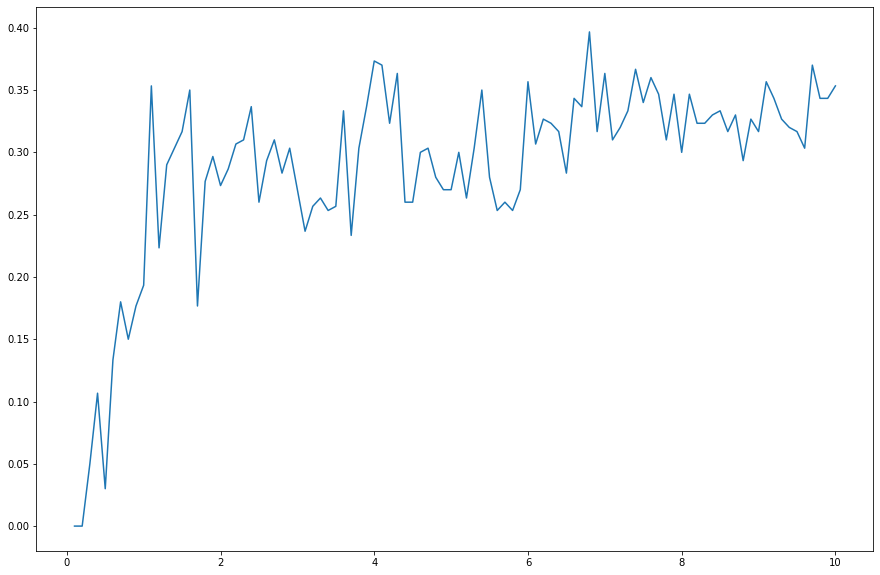

In [ ]:
N_list = [10,50,100,200,1000]

plt.figure(figsize=(15,10))
for N in N_list:
    print(f"running N = {N}")
    alpha_c = []
    error_rates = []
    for M in np.linspace(1,10*N,100):
        alpha_c.append(int(M)/N)
        error_rates.append(run_hopfield(N,1,int(M)))
    plt.plot(alpha_c, error_rates, label=f"N = {N}")

plt.xlabel(r'$\alpha_c$', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=18)
plt.title('Simulation results', fontsize=15)
plt.legend()
plt.show()

## Demonstrate Suprious Patterns

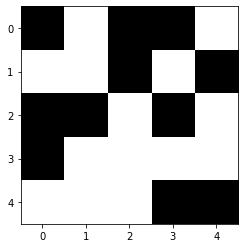

In [ ]:
# patterns
letter_T = np.array([[ 1, 1, 1, 1, 1],
                     [-1,-1, 1,-1,-1],
                     [-1,-1, 1,-1,-1],
                     [-1,-1, 1,-1,-1],
                     [-1,-1, 1,-1,-1]])
letter_O = np.array([[ 1, 1, 1, 1, 1],
                     [ 1,-1,-1,-1, 1],
                     [ 1,-1,-1,-1, 1],
                     [ 1,-1,-1,-1, 1],
                     [ 1, 1, 1, 1, 1]])
letter_N = np.array([[ 1,-1,-1,-1, 1],
                     [ 1, 1,-1,-1, 1],
                     [ 1,-1, 1,-1, 1],
                     [ 1,-1,-1, 1, 1],
                     [ 1,-1,-1,-1, 1]])
letter_Y = np.array([[ 1,-1,-1,-1, 1],
                     [-1, 1,-1, 1,-1],
                     [-1,-1, 1,-1,-1],
                     [-1,-1, 1,-1,-1],
                     [-1,-1, 1,-1,-1]])

# construct network
J = make_connection_matrix([letter_T, letter_O, letter_N, letter_Y])
S0 = make_one_pattern(5,5)

# plot initial condition
plt.imshow(S0, cmap='gray')
plt.tick_params(axis='both', left='off', bottom='off', labelleft='off', labelbottom='off')
plt.show()
S_new = S0.copy()

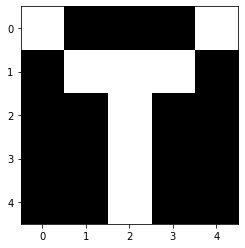

In [ ]:
# run this cells to update S
S_new = update_network_once(S_new,J)
plt.imshow(S_new, cmap='gray')
plt.tick_params(axis='both', left='off', bottom='off', labelleft='off', labelbottom='off')
plt.show()

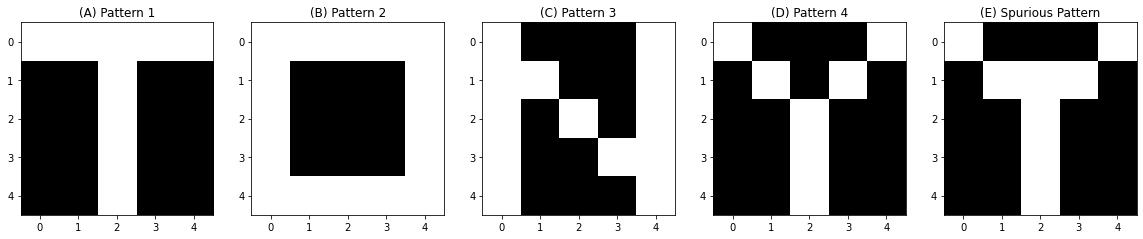

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,5,1)
plt.imshow(letter_T, cmap='gray')
plt.tick_params(axis='both', left='off', bottom='off', labelleft='off', labelbottom='off')
plt.title("(A) Pattern 1")

plt.subplot(1,5,2)
plt.imshow(letter_O, cmap='gray')
plt.tick_params(axis='both', left='off', bottom='off', labelleft='off', labelbottom='off')
plt.title("(B) Pattern 2")

plt.subplot(1,5,3)
plt.imshow(letter_N, cmap='gray')
plt.tick_params(axis='both', left='off', bottom='off', labelleft='off', labelbottom='off')
plt.title("(C) Pattern 3")

plt.subplot(1,5,4)
plt.imshow(letter_Y, cmap='gray')
plt.tick_params(axis='both', left='off', bottom='off', labelleft='off', labelbottom='off')
plt.title("(D) Pattern 4")

plt.subplot(1,5,5)
plt.imshow(S_new, cmap='gray')
plt.tick_params(axis='both', left='off', bottom='off', labelleft='off', labelbottom='off')
plt.title("(E) Spurious Pattern")
plt.show()